## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть <b>не больше 48</b>.

## Инструкция по выполнению проекта
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

# 1. Загрузка, декомпозиция и анализ данных

In [1]:
!pip install lightgbm
!pip install catboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from scipy import stats as st

from numpy.random import RandomState

In [2]:
data = pd.read_csv('C:/datasets/12/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head(20)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Выполняю ресемплирование данных по одному часу

data = data.resample('1H').sum()

data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

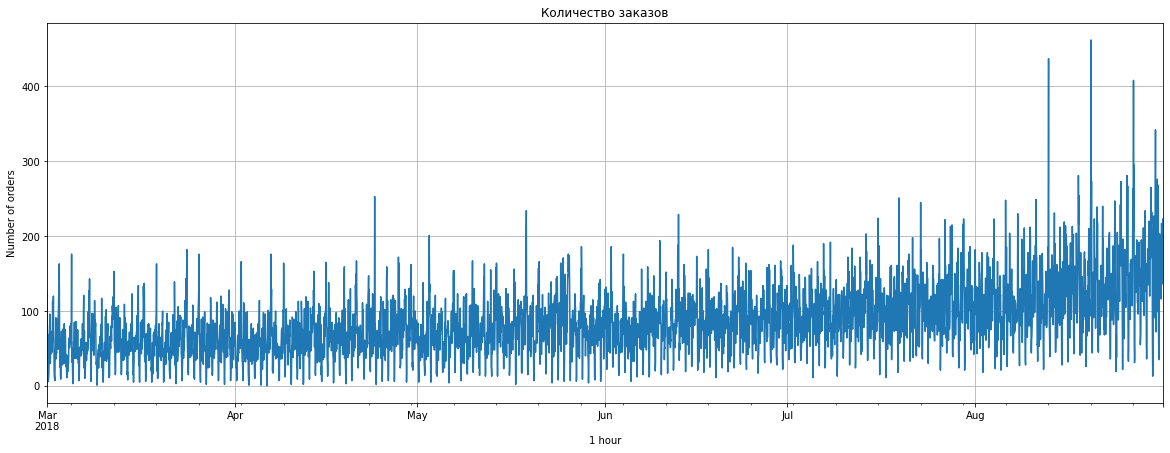

In [5]:
# Строю график по ресемплированным данным

data.plot(grid=True, legend=False, figsize=(20, 7), title='Количество заказов', xlabel='1 hour', ylabel='Number of orders')
plt.show()

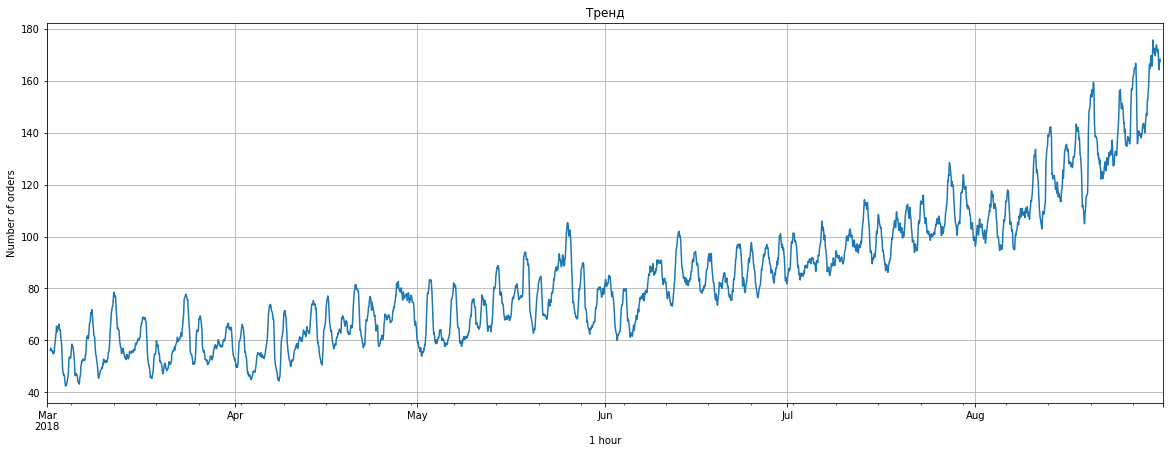

In [6]:
decomposed = seasonal_decompose(data)

decomposed.trend.plot(
    grid=True, 
    legend=False, 
    figsize=(20, 7), 
    title='Тренд', 
    xlabel='1 hour', 
    ylabel='Number of orders'
)
plt.show()

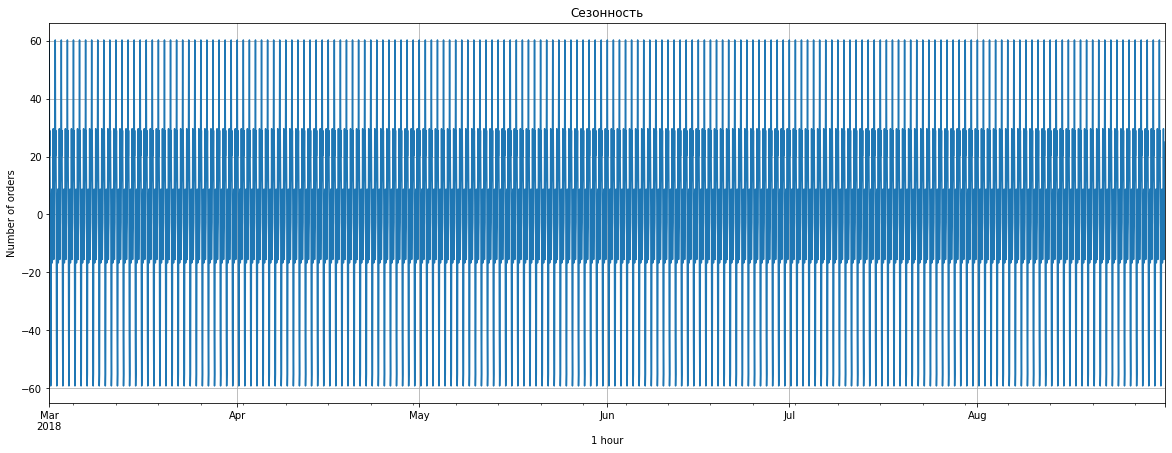

In [7]:
decomposed.seasonal.plot(
    grid=True, 
    legend=False, 
    figsize=(20, 7), 
    title='Сезонность', 
    xlabel='1 hour', 
    ylabel='Number of orders'
)
plt.show()

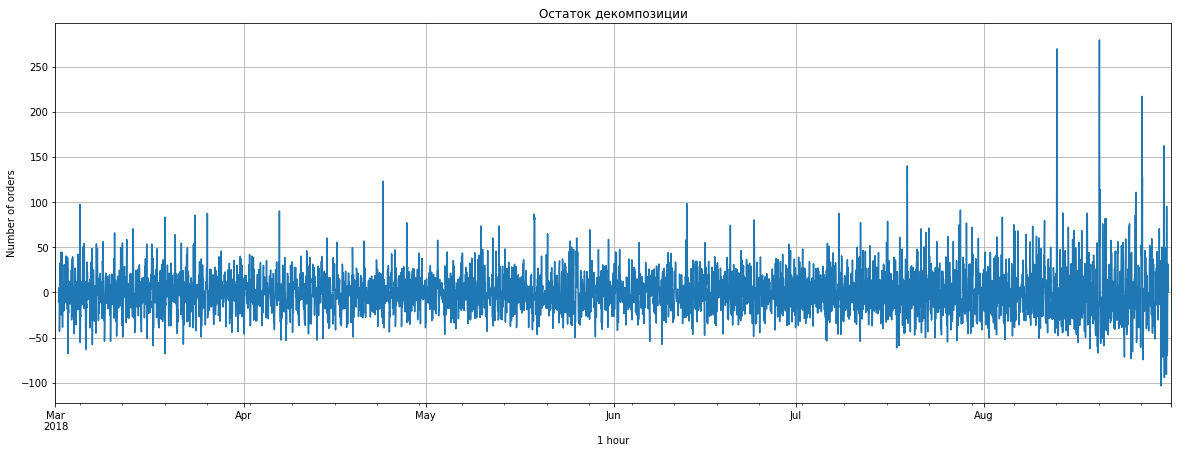

In [8]:
decomposed.resid.plot(
    grid=True, 
    legend=False, 
    figsize=(20, 7), 
    title='Остаток декомпозиции', 
    xlabel='1 hour', 
    ylabel='Number of orders'
)
plt.show()

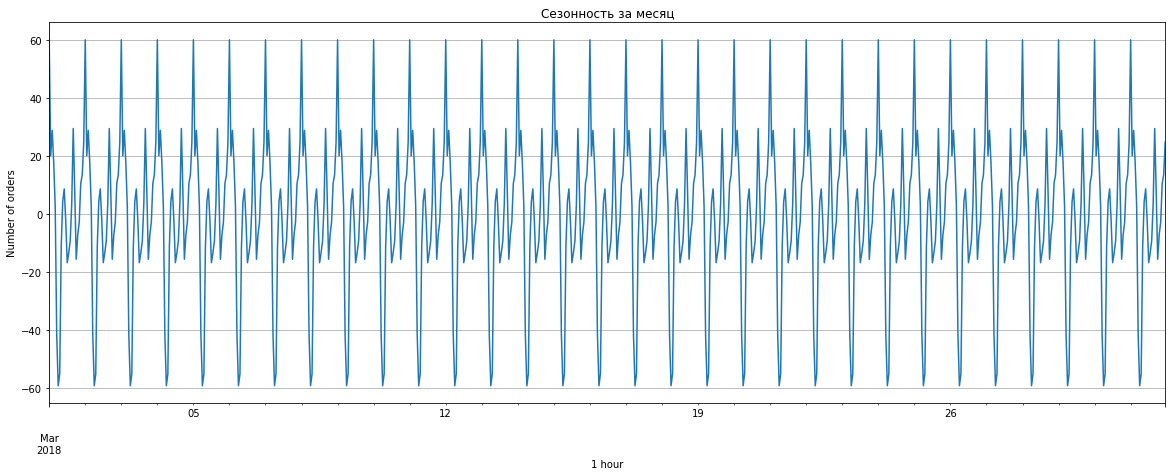

In [9]:
# Вывожу график с сезонностью за месяц

decomposed.seasonal['2018-03-01':'2018-03-31'].plot(
    grid=True, 
    legend=False, 
    figsize=(20, 7), 
    title='Сезонность за месяц', 
    xlabel='1 hour', 
    ylabel='Number of orders'
)
plt.show()

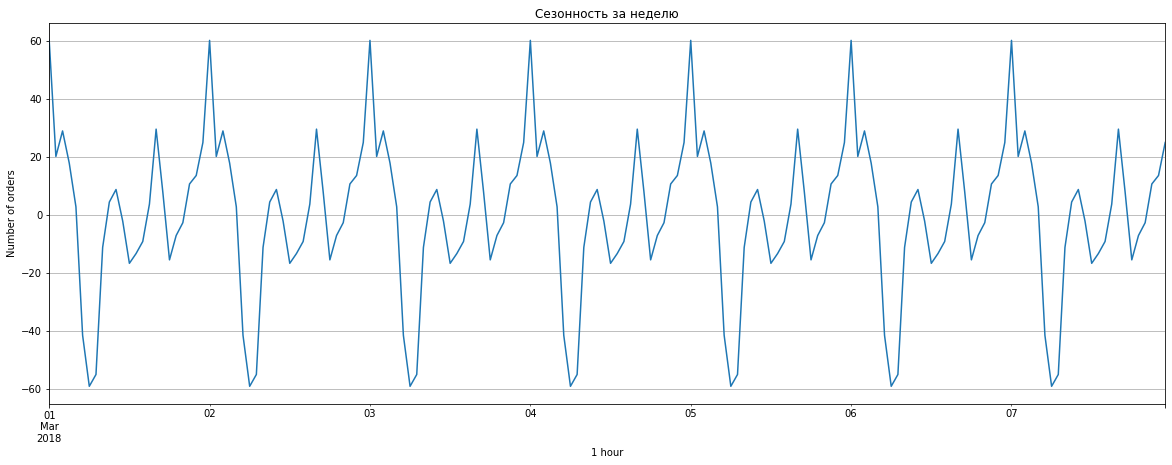

In [10]:
# Вывожу график с сезонностью за неделю

decomposed.seasonal['2018-03-01':'2018-03-07'].plot(
    grid=True, 
    legend=False, 
    figsize=(20, 7), 
    title='Сезонность за неделю', 
    xlabel='1 hour', 
    ylabel='Number of orders'
)
plt.show()

## Итоги декомпозиции данных

- На графиках количества заказов и трендов видно, что количество заказов постепенно возрастает.

- На графиках сезонности за месяц и за неделю можно заметить, что минимальное количество заказов - рано утром, а максимальное - ночью.


# 2. Создание признаков

In [12]:
# Создаю календарные признаки

data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

In [13]:
# Создаю функцию для добавления признаков

def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [14]:
# Создаю функцию для определения лучших параметров для функции make_features

def best_features(data, max_lag, rolling_mean_size, model):  
    make_features(data, max_lag, rolling_mean_size)
    data = data.dropna()
    
    features_copy = data.drop(['num_orders'], axis=1)
    target_copy = data['num_orders']
    
    features_train_copy, features_test_copy, target_train_copy, target_test_copy = train_test_split(
        features_copy, 
        target_copy, 
        shuffle=False, 
        test_size=0.2
    )
    
    model.fit(features_train_copy, target_train_copy)
    pred_copy = model.predict(features_test_copy) 
    
    return mean_squared_error(target_test_copy, pred_copy, squared=False)

In [15]:
# Создаю копию датафрейма для вычисления параметров функции make_features

data_copy = data.copy()

In [16]:
best_max_lag = None
best_rolling_mean_size = None
best_test_score = 48
model_test = LinearRegression()

for max_lag in range(1, 100):
    for rolling_mean_size in range(1, 100):
        test_score = best_features(data_copy, max_lag, rolling_mean_size, model_test)
        if test_score < best_test_score: 
            best_test_score = test_score
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            print(best_test_score, best_max_lag, best_rolling_mean_size)

print('Окончательный best_score', best_test_score)
print('Окончательный best_max_lag',best_max_lag)
print('Окончательный best_rolling_mean_size', best_rolling_mean_size)

47.59340805263464 1 1
47.541862162612176 1 2
47.050974742987655 1 24
46.7722237817027 1 25
46.59563688775195 3 24
46.313095799041854 3 25
46.1548337606538 4 25
46.10429411182537 5 25
46.09788975214645 10 25
45.99243932828023 11 25
45.99194641112528 12 25
45.83540887707317 13 25
45.7806132702682 14 24
45.487952383229846 14 25
45.28392796039958 17 25
44.23953875841661 18 24
43.88987463856381 18 25
42.59951546464728 19 24
42.407116290775 19 25
41.92552723383611 20 24
40.52511487112261 21 24
40.25623803830704 22 24


KeyboardInterrupt: 

Оптимальные параметры функции make_features:
- max_lag 96
- rolling_mean_size 20

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   month       4416 non-null   int64
 2   day         4416 non-null   int64
 3   dayofweek   4416 non-null   int64
dtypes: int64(4)
memory usage: 172.5 KB


In [18]:
make_features(data, 96, 20)

data = data.dropna()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2018-03-05 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 101 entries, num_orders to rolling_mean
dtypes: float64(97), int64(4)
memory usage: 3.4 MB


# 3. Обучение разных моделей с различными гиперпараметрами  и их анализ

In [20]:
# Создаю обучающую, валидационную и тестовую выборки

features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [21]:
# Создаю скорер метрики RMSE для подбора параметров

def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict, squared=False)
    return RMSE

scorer = make_scorer(RMSE, greater_is_better=False)

## Линейная регрессия

In [22]:
# Обучаю линейную регрессию и вычисляю метрику RMSE

model_1 = LinearRegression()

model_1_cross_val = cross_val_score(
    model_1, 
    features_train, 
    target_train, 
    scoring=scorer, 
    cv=TimeSeriesSplit()
)

print(model_1_cross_val.max())

-21.430169246121118


In [23]:
%%time
model_1.fit(features_train, target_train)

CPU times: user 152 ms, sys: 485 ms, total: 637 ms
Wall time: 624 ms


LinearRegression()

In [24]:
%%time
pred_model_1 = model_1.predict(features_test)

CPU times: user 4.56 ms, sys: 1.66 ms, total: 6.23 ms
Wall time: 3.66 ms


## Случайный лес регрессии

In [25]:
# Вычисляю оптимальные параметры для случайного леса регрессии

model_2 = RandomForestRegressor(random_state=12345)

parameters_grid_0 = {'max_depth': [2, 6, 10, 20, 40, 100],
                   'n_estimators': [25, 50, 100, 200]}

model_2_grid_cross_val = GridSearchCV(model_2, parameters_grid_0, cv=TimeSeriesSplit(), scoring=scorer)

model_2_grid_cross_val.fit(features_train, target_train)

print(model_2_grid_cross_val.best_score_)
print(model_2_grid_cross_val.best_params_)

-24.068025371887305
{'max_depth': 20, 'n_estimators': 200}


In [26]:
# Обучаю случайный лес регрессии и вычисляю метрику RMSE

model_2 = RandomForestRegressor(random_state=12345, max_depth=20, n_estimators=200)

In [27]:
%%time
model_2.fit(features_train, target_train)

CPU times: user 33.2 s, sys: 700 ms, total: 33.9 s
Wall time: 34.1 s


RandomForestRegressor(max_depth=20, n_estimators=200, random_state=12345)

In [28]:
%%time
pred_model_2 = model_2.predict(features_test)

CPU times: user 31.9 ms, sys: 4.83 ms, total: 36.8 ms
Wall time: 36.2 ms


## LGBMRegressor

In [29]:
# Провожу подбор параметров для LGBM модели методом кросс-валидации

LGBM_model = LGBMRegressor(random_state=12345)

parameters_grid_1 = {'max_depth': [2, 6, 10],
                   'learning_rate': [0.01, 0.1],
                   'n_estimators': [25, 50, 100, 200]}

LGBM_grid_cross_val = GridSearchCV(LGBM_model, parameters_grid_1, cv=TimeSeriesSplit(), scoring=scorer)

LGBM_grid_cross_val.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [2, 6, 10],
                         'n_estimators': [25, 50, 100, 200]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [30]:
print(LGBM_grid_cross_val.best_score_)
print(LGBM_grid_cross_val.best_params_)

-24.00528799564193
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}


In [29]:
# Обучаю LGBM модель и вычисляю метрику RMSE

model_LGBM = LGBMRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=12345)

In [30]:
%%time
model_LGBM.fit(features_train, target_train)

CPU times: user 12.2 s, sys: 0 ns, total: 12.2 s
Wall time: 12.2 s


LGBMRegressor(max_depth=2, n_estimators=200, random_state=12345)

In [31]:
%%time
predictions_LGBM = model_LGBM.predict(features_test)

CPU times: user 49 ms, sys: 0 ns, total: 49 ms
Wall time: 78.4 ms


## CatBoostRegressor

In [34]:
# Провожу подбор параметров для CatBoost модели методом кросс-валидации

CatBoost_model = CatBoostRegressor(random_state=12345)

parameters_grid_2 = {'max_depth': [2, 6, 10],
                   'learning_rate': [0.01, 0.1],
                   'l2_leaf_reg': [1, 3, 5, 7, 9],
                   'iterations': [50, 100, 150, 200]}

CatBoost_grid_cross_val = GridSearchCV(CatBoost_model, parameters_grid_2, cv=TimeSeriesSplit(), scoring=scorer)

CatBoost_grid_search = CatBoost_model.grid_search(parameters_grid_2, 
                                                X=features_train, 
                                                y=target_train, 
                                                plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 87.3155056	test: 86.8024339	best: 86.8024339 (0)	total: 157ms	remaining: 7.7s
1:	learn: 86.6103379	test: 86.0959836	best: 86.0959836 (1)	total: 158ms	remaining: 3.8s
2:	learn: 85.8654849	test: 85.3523483	best: 85.3523483 (2)	total: 159ms	remaining: 2.5s
3:	learn: 85.1327454	test: 84.6105813	best: 84.6105813 (3)	total: 160ms	remaining: 1.84s
4:	learn: 84.3863443	test: 83.8719152	best: 83.8719152 (4)	total: 162ms	remaining: 1.45s
5:	learn: 83.7141832	test: 83.2029014	best: 83.2029014 (5)	total: 163ms	remaining: 1.19s
6:	learn: 82.9997158	test: 82.4987440	best: 82.4987440 (6)	total: 164ms	remaining: 1s
7:	learn: 82.3190462	test: 81.8230496	best: 81.8230496 (7)	total: 165ms	remaining: 864ms
8:	learn: 81.6687618	test: 81.1731826	best: 81.1731826 (8)	total: 166ms	remaining: 754ms
9:	learn: 80.9821903	test: 80.4925031	best: 80.4925031 (9)	total: 167ms	remaining: 667ms
10:	learn: 80.2998896	test: 79.8183722	best: 79.8183722 (10)	total: 168ms	remaining: 595ms
11:	learn: 79.6259484	tes

bestTest = 22.70503438

In [35]:
CatBoost_model.get_params()

{'loss_function': 'RMSE',
 'random_state': 12345,
 'depth': 6,
 'l2_leaf_reg': 1,
 'iterations': 200,
 'learning_rate': 0.1}

In [32]:
# Обучаю CatBoost модель и вычисляю метрику RMSE

model_CatBoost = CatBoostRegressor(max_depth=6, iterations=200, learning_rate=0.1, l2_leaf_reg=1, random_state=12345)

In [33]:
%%time
model_CatBoost.fit(features_train, target_train)

0:	learn: 36.7106470	total: 79.6ms	remaining: 15.8s
1:	learn: 34.9671712	total: 102ms	remaining: 10.1s
2:	learn: 33.4693501	total: 124ms	remaining: 8.13s
3:	learn: 32.0979430	total: 151ms	remaining: 7.4s
4:	learn: 31.0372203	total: 173ms	remaining: 6.75s
5:	learn: 29.9745027	total: 195ms	remaining: 6.32s
6:	learn: 29.1059631	total: 217ms	remaining: 5.97s
7:	learn: 28.2026055	total: 243ms	remaining: 5.84s
8:	learn: 27.5875203	total: 265ms	remaining: 5.62s
9:	learn: 26.9788507	total: 290ms	remaining: 5.51s
10:	learn: 26.4377383	total: 311ms	remaining: 5.34s
11:	learn: 25.8757015	total: 343ms	remaining: 5.38s
12:	learn: 25.4296947	total: 364ms	remaining: 5.24s
13:	learn: 25.0140279	total: 388ms	remaining: 5.15s
14:	learn: 24.6792411	total: 413ms	remaining: 5.1s
15:	learn: 24.3481894	total: 441ms	remaining: 5.07s
16:	learn: 24.0698541	total: 466ms	remaining: 5.01s
17:	learn: 23.7722886	total: 488ms	remaining: 4.94s
18:	learn: 23.5209231	total: 511ms	remaining: 4.87s
19:	learn: 23.3188923	t

In [42]:
%%time
predictions_CatBoost = model_CatBoost.predict(features_test)

CPU times: user 3.49 ms, sys: 0 ns, total: 3.49 ms
Wall time: 2.47 ms


In [52]:
results = {'Модель':['LinearRegression', 'CatBoostRegressor', 'RandomForestRegressor', 'LGBMRegressor'], 
        'Скорость обучения':['8.97 ms', '831 ms', '19.6 s', '36.8 ms'],
        'Скорость предсказания': ['1.99 ms', '2.99 ms', '26.9 ms', '2.38 ms'],
        'Качество предсказания': [21.42, 22.70, 24.06, 24.00]}
results = pd.DataFrame(results)
results

,Модель,Скорость обучения,Скорость предсказания,Качество предсказания
0,LinearRegression,8.97 ms,1.99 ms,21.42
1,CatBoostRegressor,831 ms,2.99 ms,22.70
2,RandomForestRegressor,19.6 s,26.9 ms,24.06
3,LGBMRegressor,36.8 ms,2.38 ms,24.00


## Итоги подбора параметров и обучения моделей 

Показатели метрики RMSE у разных моделей (от лучшей к худшей)

1. Значение метрики RMSE у линейной регрессии: <b>21.42793947183683</b>
2. Значение метрики RMSE у CatBoost модели: <b>22.70503438</b>
3. Значение метрики RMSE у LGBM  модели: <b>24.00528799564193</b>
4. Значение метрики RMSE у случайного леса регрессии: <b>24.068025371887305</b>

Скорость моделей (Wall time):
- Время обучения линейной регрессии - <b>8.97 ms</b>. Время предсказания линейной регрессии - <b>1.99 ms</b>.
- Время обучения случайного леса регрессии - <b>19.6 s</b>. Время предсказания случайного леса регрессии - <b>26.9 ms</b>.
- Время обучения модели LGBM - <b>36.8 ms</b>. Время предсказания модели LGBM - <b>2.38 ms</b>.
- Время обучения модели CatBoost - <b>866 ms</b>. Время предсказания модели CatBoost - <b>4.98 ms</b>.

Таким образом, лучшие паказатели метрики RMSE у <b>линейной регрессии</b>, также данная модель обладает самой высокой скоростью обучения и предсказания. 


# 4. Проверка лучшей модели на тестовой выборке

In [37]:
# Проверяю значение метрики RMSE на тестовой выборке у лучшей модели

print(
    'Значение метрики RMSE на тестовой выборке у линейной регрессии:', 
    mean_squared_error(target_test, 
                       pred_model_1, 
                       squared=False)
)

Значение метрики RMSE на тестовой выборке у линейной регрессии: 41.91329335906456


In [38]:
# Проверяю значение метрики RMSE на тестовой выборки у второй по качеству модели

print(
    'Значение метрики RMSE на тестовой выборке у CatBoost модели:', 
    mean_squared_error(target_test, 
                       predictions_CatBoost, 
                       squared=False)
)

Значение метрики RMSE на тестовой выборке у CatBoost модели: 37.76748365850998


## Итоги проверки модели на тестовой выборке

Значение метрики RMSE на тестовой выборке у линейной регрессии: <b>41.90962467324348</b>, то есть меньше 48, поэтому поставленная задача выполнена.

Значение метрики RMSE на тестовой выборке у второй по качеству модели (CatBoost): <b>37.76748365850998</b>, оно оказалось даже лучше, чем у линейной регрессии.


In [64]:
def plot_actual_predict(actual_, predict):#, num_points): #, num_points, title):
    '''
    Наш графический анализ
    '''
    #actual_ = actual[num_points:]
    pferict_data = pd.DataFrame(predict,index=actual_.index)
    plt.figure(figsize=(16, 7))
    plt.plot(actual_, 'ro', color='steelblue', linestyle='-', label="Факт")
    plt.title('ГРАФИЧЕСКИЙ АНАЛИЗ ФАКТ-ПЛАН', y = 1.03)
    plt.plot(pferict_data, 'ro',  color='r', linestyle='--', label="Прогноз")
    plt.legend()
    plt.xlabel("Дата и время")
    plt.ylabel("Число заказов")
    plt.grid(True)
    plt.show()

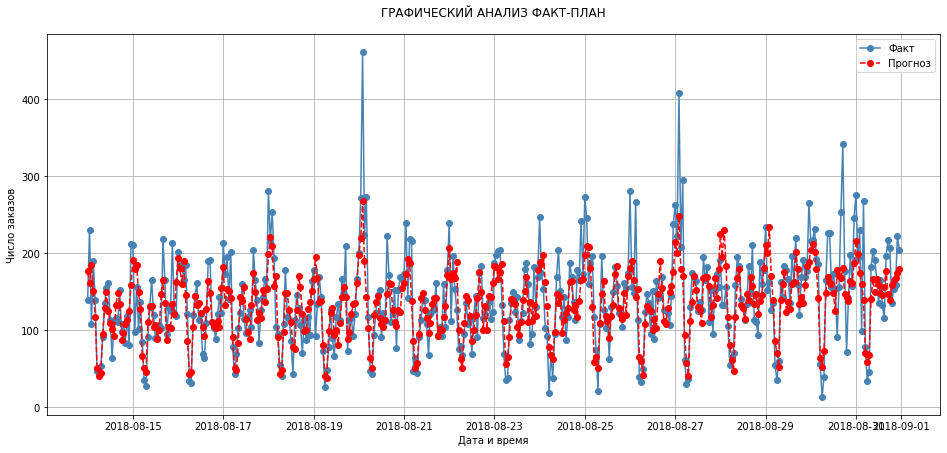

In [65]:
plot_actual_predict(pd.Series(target_test), predictions_CatBoost.tolist())

# 5. Вывод

## Итоги декомпозиции данных

- На графиках количества заказов и трендов видно, что количество заказов постепенно возрастает.

- На графиках сезонности за месяци за неделю можно заметить, что минимальное количество заказов - рано утром, а максимальное - ночью.

## Итоги подбора параметров и обучения моделей 

Показатели метрики RMSE у разных моделей (от лучшей к худшей)

1. Значение метрики RMSE у линейной регрессии: <b>21.42793947183683</b>
2. Значение метрики RMSE у CatBoost модели: <b>22.70503438</b>
3. Значение метрики RMSE у LGBM  модели: <b>24.00528799564193</b>
4. Значение метрики RMSE у случайного леса регрессии: <b>24.068025371887305</b>

Скорость моделей (Wall time):
- Время обучения линейной регрессии - <b>8.97 ms</b>. Время предсказания линейной регрессии - <b>1.99 ms</b>.
- Время обучения случайного леса регрессии - <b>19.6 s</b>. Время предсказания случайного леса регрессии - <b>26.9 ms</b>.
- Время обучения модели LGBM - <b>36.8 ms</b>. Время предсказания модели LGBM - <b>2.38 ms</b>.
- Время обучения модели CatBoost - <b>866 ms</b>. Время предсказания модели CatBoost - <b>4.98 ms</b>.

Таким образом, лучшие паказатели метрики RMSE у <b>линейной регрессии</b>, также данная модель обладает самой высокой скоростью обучения и предсказания. 


## Итоги проверки модели на тестовой выборке

Значение метрики RMSE на тестовой выборке у линейной регрессии: <b>41.90962467324348</b>, то есть меньше 48, поэтому поставленная задача выполнена.

Значение метрики RMSE на тестовой выборке у второй по качеству модели (CatBoost): <b>37.76748365850998</b>, оно оказалось даже лучше, чем у линейной регрессии.

